<a href="https://colab.research.google.com/github/hsnbnaa/deep-learning-is-easy/blob/main/Week%207/Google%20Colab/Tugas_Week_7_Deep_RNN_Tensorflow_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt

# Preprocessing Data

In [ ]:
vocab_size = 30000
maxlen = 300

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Deep RNN Model IMDB Dataset

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embedding_output_dim', [32, 64, 128]),
        input_length=maxlen
    ))

    # Deep RNN tanpa bidirectional
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units_1', [32, 64, 128]),
        return_sequences=True
    ))
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units_2', [32, 64, 128]),
        return_sequences=True
    ))
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units_3', [32, 64, 128]),
        return_sequences=False
    ))

    model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = RMSprop(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Inisialisasi tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='birnn_tuning'
)

# Mulai pencarian
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Dapatkan model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

# Lihat parameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Trial 10 Complete [00h 08m 13s]
val_accuracy: 0.8100000023841858

Best val_accuracy So Far: 0.8679999709129333
Total elapsed time: 01h 39m 12s
Best Hyperparameters:
embedding_output_dim: 128
rnn_units_1: 64
rnn_units_2: 32
rnn_units_3: 128
dropout_rate: 0.4
optimizer: rmsprop
learning_rate: 0.00023325852334238442


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Simpan hasil training best trial
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Buat ulang model
model = build_model(best_hps)

# Training ulang dan simpan history
history_rnn = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - accuracy: 0.5674 - loss: 0.6769 - val_accuracy: 0.8140 - val_loss: 0.4115
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 80ms/step - accuracy: 0.8552 - loss: 0.3474 - val_accuracy: 0.8712 - val_loss: 0.3172
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.9026 - loss: 0.2560 - val_accuracy: 0.8740 - val_loss: 0.3151
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.9335 - loss: 0.1848 - val_accuracy: 0.8502 - val_loss: 0.3819
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.9572 - loss: 0.1265 - val_accuracy: 0.8792 - val_loss: 0.3890
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9729 - loss: 0.0821 - val_accuracy: 0.8592 - val_loss: 0.4870
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.9874 - loss: 0.0396 - val_accuracy: 0.8452 - val_loss: 0.5743
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.9931 - loss: 0.0212 - 

In [ ]:
# Prediksi
y_pred_rnn = best_model.predict(X_test)
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step


In [ ]:
# Evaluasi
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn)
recall_rnn = recall_score(y_test, y_pred_rnn)
f1_rnn = f1_score(y_test, y_pred_rnn)

print(f"Accuracy: {accuracy_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"Recall: {recall_rnn:.4f}")
print(f"F1-score: {f1_rnn:.4f}")

Accuracy: 0.8678
Precision: 0.8497
Recall: 0.8937
F1-score: 0.8711


782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step


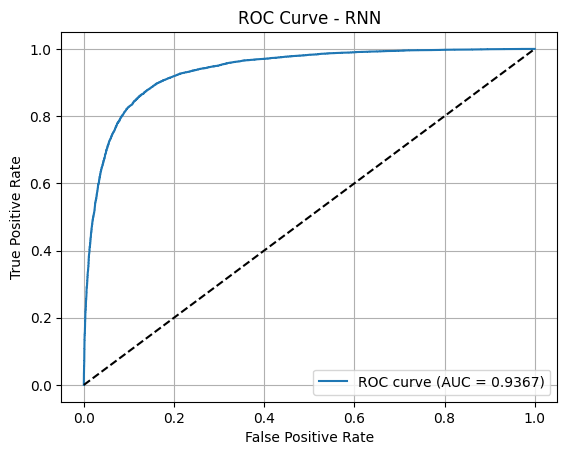

In [ ]:
# Dapatkan probabilitas prediksi
y_prob_rnn = best_model.predict(X_test).ravel()

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rnn)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal random
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

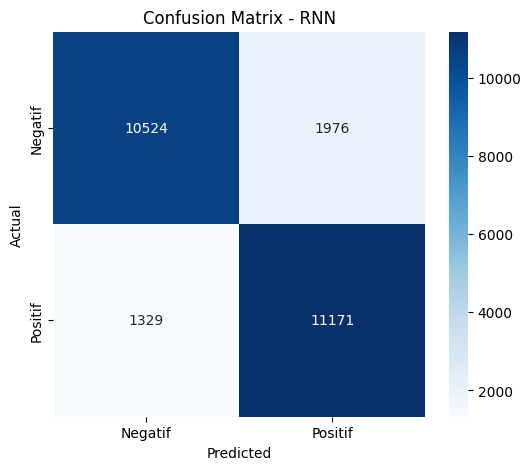

In [ ]:
# Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

# Visualisasi pakai seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RNN')
plt.show()

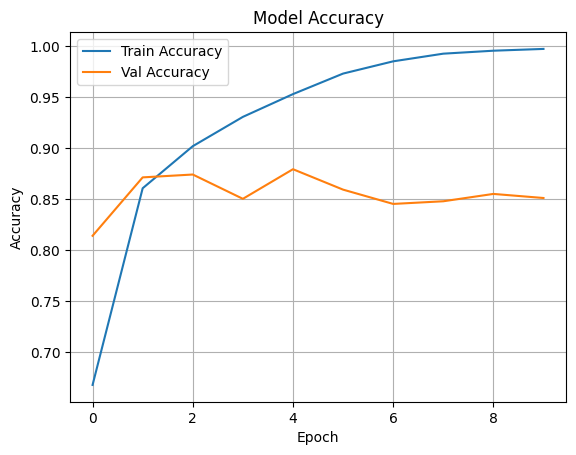

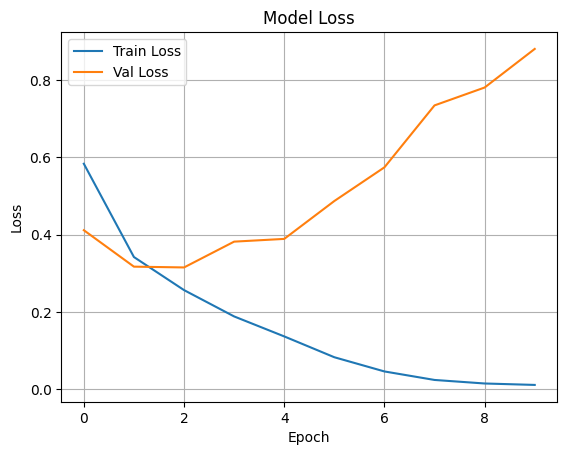

In [ ]:
# Akurasi
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Deep RNN Model Review Toko Baju Dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import keras_tuner as kt

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv')

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# ==== Hyperparameter ====
epochs = 10
num_words = 15000
maxlen = 200
batch_size = 256
embed_dim = 128
hidden_dim = 256
num_layers = 2
dropout_prob = 0.15

In [ ]:
# ==== Tentukan kolom yang digunakan ====
review_col = 'Review Text'
rating_col = 'Rating'

# ==== Cek dan isi NaN ====
data[review_col] = data[review_col].fillna("").astype(str)

# ==== Preprocessing Teks ====
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)     # Hapus tanda baca
        text = re.sub(r'\d+', '', text)         # Hapus angka
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        return ' '.join([w for w in words if w not in stop_words])
    else:
        return ""

data['processed_review'] = data[review_col].apply(preprocess_text)

In [ ]:
# ==== Labeling ====
rating_threshold = 3
data['sentiment'] = (data[rating_col] > rating_threshold).astype(int)

# ==== Buat Vocabulary ====
def build_vocab(texts, max_words=num_words):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    vocab = {word: idx+1 for idx, (word, _) in enumerate(word_counts.most_common(max_words - 1))}
    vocab[''] = 0
    return vocab

vocabulary = build_vocab(data['processed_review'].tolist(), max_words=num_words)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 15000


In [ ]:
# ==== Convert teks ke sequence ====
def text_to_sequence(text, vocab, maxlen):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]  # 0 untuk OOV dan padding
    if len(sequence) > maxlen:
        return sequence[:maxlen]
    else:
        return sequence + [0] * (maxlen - len(sequence))

data['sequence'] = data['processed_review'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

In [ ]:
# ==== Split Dataset ====
X = np.array(data['sequence'].tolist())
y = np.array(data['sentiment'].tolist())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def build_deep_rnn_model(hp):
    model = Sequential()

    # Embedding
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int('embed_dim', min_value=32, max_value=128, step=32),
        mask_zero=False
    ))

    # RNN layers (deep, non-bidirectional)
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)
    hidden_dim = hp.Int('hidden_dim', min_value=32, max_value=128, step=32)

    for i in range(num_layers - 1):
        model.add(SimpleRNN(
            hidden_dim,
            return_sequences=True,
            dropout=0.3,
            kernel_initializer='orthogonal',
            recurrent_initializer='orthogonal',
            bias_initializer='zeros'
        ))

    # Last RNN layer
    model.add(SimpleRNN(
        hidden_dim,
        return_sequences=True,  # still needed for GlobalMaxPooling1D
        dropout=0.3,
        kernel_initializer='orthogonal',
        recurrent_initializer='orthogonal',
        bias_initializer='zeros'
    ))

    # Global Max Pooling
    model.add(GlobalMaxPooling1D())

    # Dense + Dropout
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_deep_rnn_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='binn_tuning_dir',
    project_name='birnn_tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)


Trial 10 Complete [00h 05m 34s]
val_accuracy: 0.7770090699195862

Best val_accuracy So Far: 0.8744012713432312
Total elapsed time: 00h 40m 54s


In [ ]:
best_model_review = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Optional: retrain for visualization or better final model
history_rnn = best_model_review.fit(X_train, y_train, epochs=10, validation_split=0.2)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


470/470 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9144 - loss: 0.2309 - val_accuracy: 0.8715 - val_loss: 0.3195
Epoch 2/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9200 - loss: 0.2138 - val_accuracy: 0.8733 - val_loss: 0.3260
Epoch 3/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9261 - loss: 0.2015 - val_accuracy: 0.8696 - val_loss: 0.3378
Epoch 4/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9269 - loss: 0.1955 - val_accuracy: 0.8654 - val_loss: 0.3412
Epoch 5/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9369 - loss: 0.1762 - val_accuracy: 0.8675 - val_loss: 0.3546
Epoch 6/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9397 - loss: 0.1725 - val_accuracy: 0.8643 - val_loss: 0.3517
Epoch 7/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9439 - loss: 0.1602 - val_accuracy: 0.8646 - val_loss: 0.3515
Epoch 8/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9470 - loss: 0.1501 - val_accuracy: 0.

In [ ]:
y_pred_rnn = best_model_review.predict(X_test)
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)

147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [ ]:
# Evaluasi
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
recall_rnn = recall_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
f1_rnn = f1_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'

print(f"Accuracy: {accuracy_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"Recall: {recall_rnn:.4f}")
print(f"F1-score: {f1_rnn:.4f}")


Accuracy: 0.8702
Precision: 0.8668
Recall: 0.8702
F1-score: 0.8680


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


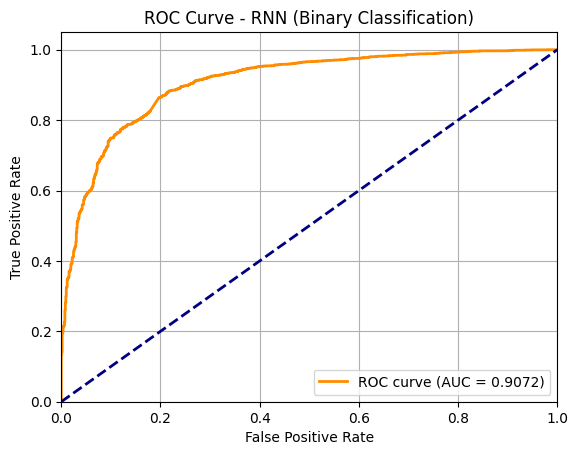

In [ ]:
y_prob_rnn = best_model_review.predict(X_test)  # output dari sigmoid, bentuknya (n_samples, 1)
y_prob_rnn = y_prob_rnn.ravel()  # pipihkan dari (n_samples, 1) ke (n_samples,)

# Hitung ROC dan AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_rnn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

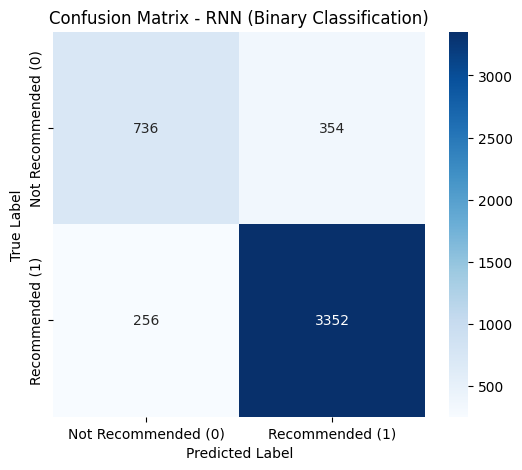

In [ ]:
# Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

# Visualisasi dengan seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Recommended (0)', 'Recommended (1)'],
            yticklabels=['Not Recommended (0)', 'Recommended (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RNN (Binary Classification)')
plt.show()

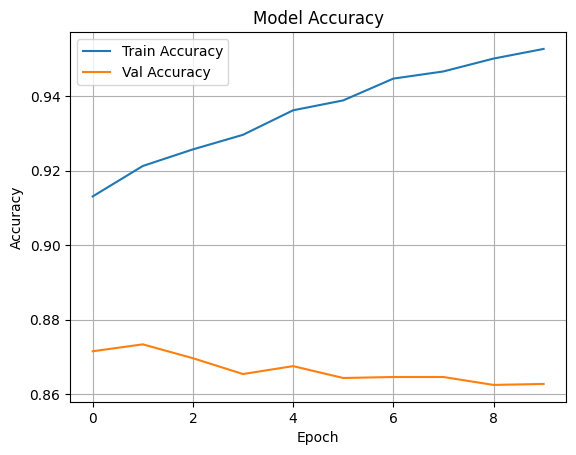

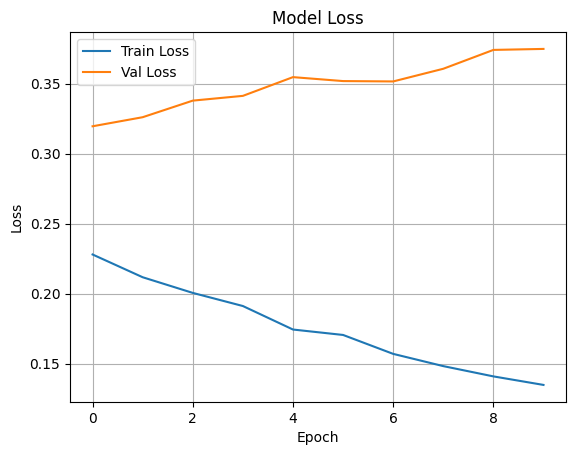

In [ ]:
# Akurasi
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Deteksi Sarkasme

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import keras_tuner as kt

## Preprocessing

In [3]:
data = pd.read_json('https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json', lines=True)

In [4]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
texts = data['headline'].values
labels = data['is_sarcastic'].values

In [6]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

In [7]:
maxlen = 150  # atau pakai nilai berdasarkan distribusi panjang headline
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')


In [8]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [9]:
def model_builder(hp, vocab_size=10000):
    model = Sequential()

    # Embedding layer
    embed_dim = hp.Choice('embed_dim', values=[32, 64, 128])
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=False))

    # Hyperparameter layer settings
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)
    hidden_dim = hp.Choice('hidden_dim', values=[64, 128, 256])

    # Deep RNN layers (non-bidirectional)
    for i in range(num_layers - 1):
        model.add(SimpleRNN(units=hidden_dim,
                            return_sequences=True,
                            dropout=0.3,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))

    # Last RNN layer
    model.add(SimpleRNN(units=hidden_dim,
                        return_sequences=True,
                        dropout=0.3,
                        kernel_initializer='orthogonal',
                        recurrent_initializer='orthogonal',
                        bias_initializer='zeros'))

    # Global pooling
    model.add(GlobalMaxPooling1D())

    # Fully connected
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [10]:
tuner = kt.RandomSearch(
    model_builder,                     # fungsi model
    objective='val_accuracy',         # metrik yang ingin dioptimalkan
    max_trials=10,                    # jumlah kombinasi hyperparameter yang dicoba
    executions_per_trial=1,          # eksekusi per percobaan (bisa lebih dari 1 untuk averaging)
    directory='my_dir',              # direktori untuk menyimpan hasil tuning
    project_name='birnn_random_tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Trial 10 Complete [00h 05m 18s]
val_accuracy: 0.8528310656547546

Best val_accuracy So Far: 0.856106698513031
Total elapsed time: 00h 28m 10s


In [11]:
best_model_sarkas = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Optional: retrain for visualization or better final model
history_rnn = best_model_sarkas.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


535/535 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9591 - loss: 0.1212 - val_accuracy: 0.8545 - val_loss: 0.4116
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9624 - loss: 0.1103 - val_accuracy: 0.8500 - val_loss: 0.4220
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9671 - loss: 0.0977 - val_accuracy: 0.8496 - val_loss: 0.4692
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9676 - loss: 0.0924 - val_accuracy: 0.8493 - val_loss: 0.4920
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9733 - loss: 0.0728 - val_accuracy: 0.8449 - val_loss: 0.4763
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9800 - loss: 0.0599 - val_accuracy: 0.8418 - val_loss: 0.5152
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9797 - loss: 0.0555 - val_accuracy: 0.8421 - val_loss: 0.5667
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9826 - loss: 0.0499 - val_accuracy: 

In [12]:
y_pred_rnn = best_model_sarkas.predict(X_test)
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [13]:
# Evaluasi
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
recall_rnn = recall_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
f1_rnn = f1_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'

print(f"Accuracy: {accuracy_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"Recall: {recall_rnn:.4f}")
print(f"F1-score: {f1_rnn:.4f}")


Accuracy: 0.8371
Precision: 0.8382
Recall: 0.8371
F1-score: 0.8374


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


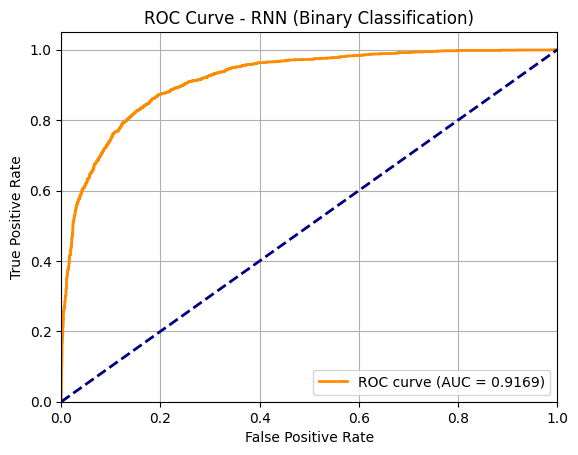

In [14]:
y_prob_rnn = best_model_sarkas.predict(X_test)  # output dari sigmoid, bentuknya (n_samples, 1)
y_prob_rnn = y_prob_rnn.ravel()  # pipihkan dari (n_samples, 1) ke (n_samples,)

# Hitung ROC dan AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_rnn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

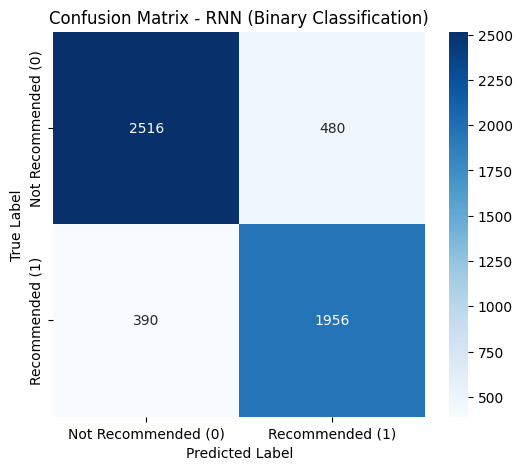

In [15]:
# Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

# Visualisasi dengan seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Recommended (0)', 'Recommended (1)'],
            yticklabels=['Not Recommended (0)', 'Recommended (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RNN (Binary Classification)')
plt.show()

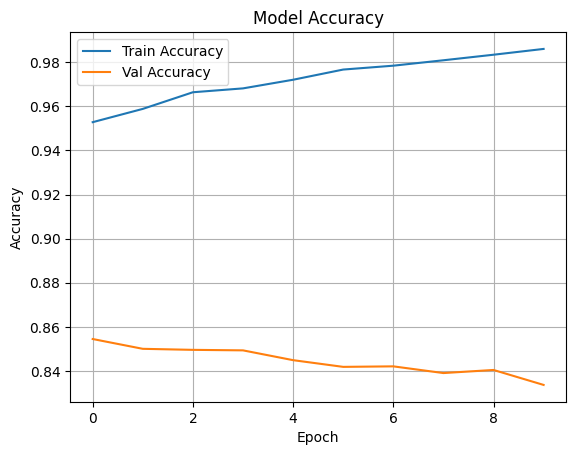

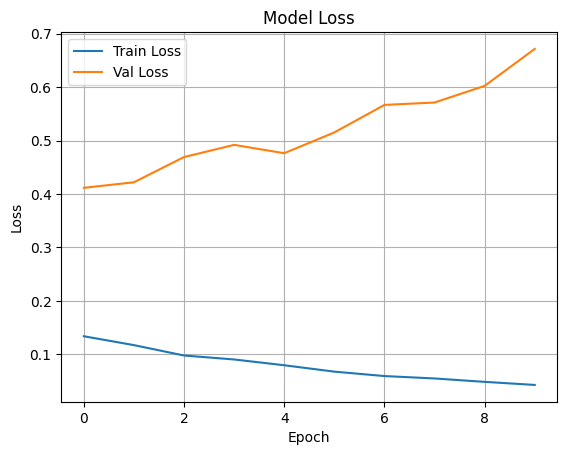

In [16]:
# Akurasi
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()